In [1]:
import pandas as pd
import numpy as np
import os
import json

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as skmet
from sklearn import preprocessing

In [2]:
# DATA PATHS
ROOT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/3x3_example/"
czi_path = f"{ROOT_DIR}3x3-extract-Scene6-07-14to15_stitched.czi"
trackmate_path = f"{ROOT_DIR}filtered_spots.csv"
annotations_path = f"{ROOT_DIR}annotations.coco"
tiff_path = f"{ROOT_DIR}composite.tif"

In [3]:
df = pd.read_csv(trackmate_path)
print(f"{df.shape=}")

df.shape=(4069, 48)


In [4]:
ann = json.load(open(annotations_path))
print(f"{ann.keys()=}")

ann_df = pd.DataFrame(ann['annotations'])
file_ids = pd.DataFrame(ann['images'])

ann_df = ann_df[['image_id', 'category_id']]
ann_df = ann_df.rename({'image_id': 'id'}, axis=1)
file_ids = file_ids[['id', 'file_name']]

get_track = lambda x: int(x.split("_")[0].replace("track", ""))
get_frame = lambda x: int(x.split("_")[1].replace("frame", "").replace(".png", ""))

ann_df = pd.merge(ann_df, file_ids, on='id', how='left')
ann_df['TRACK_ID'] = ann_df['file_name'].apply(get_track)
ann_df['FRAME'] = ann_df['file_name'].apply(get_frame)

label2label = {
    1 : "G1",
    2 : "S",
    3 : "G2/M",
    4 : 'NA',
}


ann_df = ann_df.replace({"category_id": label2label})


print(f"{ann_df.shape=}")
ann_df.head()

ann.keys()=dict_keys(['info', 'licenses', 'annotations', 'categories', 'images'])
ann_df.shape=(1371, 5)


,id,category_id,file_name,TRACK_ID,FRAME
0,1,G1,track29_frame0.png,29,0
1,2,G1,track29_frame1.png,29,1
2,3,G1,track29_frame2.png,29,2
3,4,G1,track29_frame3.png,29,3
4,5,G1,track29_frame4.png,29,4


In [5]:
df = pd.merge(
    df, ann_df, 
    on=['TRACK_ID', 'FRAME'],
    how='left'
)

print(f"{df.shape=}")


df2 = df[df['category_id'].notna()]
print(f"{df2.shape=}")

df.shape=(4069, 51)
df2.shape=(1371, 51)


In [6]:
df2['category_id'].value_counts(dropna=False)

NA      562
G1      357
S       308
G2/M    144
Name: category_id, dtype: int64

In [8]:
def col_renamer(df, str_match, new_name):
    """A function to rename columns with a substrig substitution """
    old_names = [x for x in df.columns if str_match in x]
    new_names = [x.replace(str_match, new_name) for x in old_names]
    rename_dict = dict(zip(old_names, new_names))
    
    df = df.rename(columns=rename_dict)
    return df

# rename some columns
df2 = col_renamer(df2, 'CH1', 'RED')
df2 = col_renamer(df2, 'CH2', 'GREEN')
df2 = col_renamer(df2, 'CH3', 'BLUE')

In [9]:
df2.columns

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED',
       'MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED',
       'STD_INTENSITY_RED', 'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN',
       'MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN',
       'STD_INTENSITY_GREEN', 'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE',
       'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE',
       'STD_INTENSITY_BLUE', 'CONTRAST_RED', 'SNR_RED', 'CONTRAST_GREEN',
       'SNR_GREEN', 'CONTRAST_BLUE', 'SNR_BLUE', 'ELLIPSE_X0', 'ELLIPSE_Y0',
       'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'STEP', 'MAX_STEP', 'id', 'category_id', 'file_name'],
      dtype='object')

In [10]:



X = [
    'MEAN_INTENSITY_RED', 'MEDIAN_INTENSITY_RED','MIN_INTENSITY_RED', 'MAX_INTENSITY_RED', 'TOTAL_INTENSITY_RED', 'STD_INTENSITY_RED', 'CONTRAST_RED', 'SNR_RED', 
    'MEAN_INTENSITY_GREEN', 'MEDIAN_INTENSITY_GREEN','MIN_INTENSITY_GREEN', 'MAX_INTENSITY_GREEN', 'TOTAL_INTENSITY_GREEN', 'STD_INTENSITY_GREEN', 'CONTRAST_GREEN', 'SNR_GREEN', 
    'MEAN_INTENSITY_BLUE', 'MEDIAN_INTENSITY_BLUE', 'MIN_INTENSITY_BLUE', 'MAX_INTENSITY_BLUE', 'TOTAL_INTENSITY_BLUE','STD_INTENSITY_BLUE', 'CONTRAST_BLUE', 'SNR_BLUE', 
    'RADIUS', 'ELLIPSE_X0', 'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA', 'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
]


one_hot = pd.get_dummies(df2['category_id'])
df2 = df2.join(one_hot)

y = ['G1', 'S', 'G2/M', 'NA']

print(f"{df2[X].shape=}")
print(f"{df2[y].shape=}")

pd.options.mode.use_inf_as_na = True
df2[X].isna().sum()

# df2[X].dtypes


df2[X].shape=(1371, 35)
df2[y].shape=(1371, 4)


MEAN_INTENSITY_RED        0
MEDIAN_INTENSITY_RED      0
MIN_INTENSITY_RED         0
MAX_INTENSITY_RED         0
TOTAL_INTENSITY_RED       0
STD_INTENSITY_RED         0
CONTRAST_RED              6
SNR_RED                   6
MEAN_INTENSITY_GREEN      0
MEDIAN_INTENSITY_GREEN    0
MIN_INTENSITY_GREEN       0
MAX_INTENSITY_GREEN       0
TOTAL_INTENSITY_GREEN     0
STD_INTENSITY_GREEN       0
CONTRAST_GREEN            6
SNR_GREEN                 6
MEAN_INTENSITY_BLUE       0
MEDIAN_INTENSITY_BLUE     0
MIN_INTENSITY_BLUE        0
MAX_INTENSITY_BLUE        0
TOTAL_INTENSITY_BLUE      0
STD_INTENSITY_BLUE        0
CONTRAST_BLUE             6
SNR_BLUE                  6
RADIUS                    6
ELLIPSE_X0                0
ELLIPSE_Y0                0
ELLIPSE_MAJOR             0
ELLIPSE_MINOR             0
ELLIPSE_THETA             0
ELLIPSE_ASPECTRATIO       0
AREA                      0
PERIMETER                 0
CIRCULARITY               0
SOLIDITY                  0
dtype: int64

In [11]:
# handle in values
for c in X:
    if df2[c].isna().sum() > 0:
        df2[c] = np.where(df2[c].isna(), df2[c].max(), df2[c])
        
df2[X].isna().sum()

MEAN_INTENSITY_RED        0
MEDIAN_INTENSITY_RED      0
MIN_INTENSITY_RED         0
MAX_INTENSITY_RED         0
TOTAL_INTENSITY_RED       0
STD_INTENSITY_RED         0
CONTRAST_RED              0
SNR_RED                   0
MEAN_INTENSITY_GREEN      0
MEDIAN_INTENSITY_GREEN    0
MIN_INTENSITY_GREEN       0
MAX_INTENSITY_GREEN       0
TOTAL_INTENSITY_GREEN     0
STD_INTENSITY_GREEN       0
CONTRAST_GREEN            0
SNR_GREEN                 0
MEAN_INTENSITY_BLUE       0
MEDIAN_INTENSITY_BLUE     0
MIN_INTENSITY_BLUE        0
MAX_INTENSITY_BLUE        0
TOTAL_INTENSITY_BLUE      0
STD_INTENSITY_BLUE        0
CONTRAST_BLUE             0
SNR_BLUE                  0
RADIUS                    0
ELLIPSE_X0                0
ELLIPSE_Y0                0
ELLIPSE_MAJOR             0
ELLIPSE_MINOR             0
ELLIPSE_THETA             0
ELLIPSE_ASPECTRATIO       0
AREA                      0
PERIMETER                 0
CIRCULARITY               0
SOLIDITY                  0
dtype: int64

In [12]:
df2[y].value_counts()

G1  S  G2/M  NA
0   0  0     1     562
1   0  0     0     357
0   1  0     0     308
    0  1     0     144
dtype: int64

In [13]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df2[X], df2[y], test_size=0.05)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

print(f"\n{X_train.shape=}")
print(f"{y_train.shape=}")

print(f"\n{X_test.shape=}")
print(f"{y_test.shape=}")

print(f"\n{X_holdout.shape=}")
print(f"{y_holdout.shape=}")


X_train.shape=(911, 35)
y_train.shape=(911, 4)

X_test.shape=(391, 35)
y_test.shape=(391, 4)

X_holdout.shape=(69, 35)
y_holdout.shape=(69, 4)


In [14]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X

# use the trainning data to transform the testing data
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

X_holdout = scaler.transform(X_holdout)
X_holdout = pd.DataFrame(X_holdout)
print("done.")

done.


In [15]:
model = RandomForestClassifier(bootstrap=True,
                               n_estimators=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
auc = skmet.roc_auc_score(y_test, y_pred, multi_class='ovo')
print(f"{auc=:.5f}")
print()

target_names = ['G1', 'S', 'G2/M', 'NA']
cm = skmet.confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
cm = pd.DataFrame(cm)
cm.index = target_names
cm.columns = target_names
print(cm)

print()
report = skmet.classification_report(y_test, y_pred, target_names=target_names)
print(report)

auc=0.97104

       G1   S  G2/M   NA
G1    105   0     3    2
S       3  78     0    2
G2/M    1   1    38    0
NA      4   0     0  154

              precision    recall  f1-score   support

          G1       0.99      0.94      0.96       110
           S       0.99      0.94      0.96        83
        G2/M       0.93      0.95      0.94        40
          NA       0.97      0.97      0.97       158

   micro avg       0.98      0.95      0.97       391
   macro avg       0.97      0.95      0.96       391
weighted avg       0.98      0.95      0.97       391
 samples avg       0.95      0.95      0.95       391



/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

feature_importances['cumsum'] = feature_importances['importance'].cumsum()
feature_importances.head(20).round(3)

,importance,cumsum
MEDIAN_INTENSITY_GREEN,0.091,0.091
MEAN_INTENSITY_RED,0.080,0.171
SNR_GREEN,0.078,0.249
MEDIAN_INTENSITY_RED,0.078,0.327
CONTRAST_GREEN,0.077,0.404
TOTAL_INTENSITY_GREEN,0.073,0.477
MEAN_INTENSITY_GREEN,0.062,0.539
CONTRAST_RED,0.052,0.591
SNR_RED,0.049,0.640
STD_INTENSITY_GREEN,0.047,0.687


In [17]:
# run some predictions

# load in the original data set

trackmate_path = f"{ROOT_DIR}spots.csv"
df = pd.read_csv(trackmate_path, skiprows=[1, 2, 3])

# rename some columns
df = col_renamer(df, 'CH1', 'RED')
df = col_renamer(df, 'CH2', 'GREEN')
df = col_renamer(df, 'CH3', 'BLUE')

for c in X:
    if df[c].isna().sum() > 0:
        df[c] = np.where(df[c].isna(), df[c].max(), df[c])

states = model.predict(scaler.transform(df[X]))
states = pd.DataFrame(states)
states.columns = target_names 

df = df.join(states)
df['estimate'] = df[target_names].idxmax(axis=1)
print(f"{df.shape=}")

df.shape=(9160, 51)


In [18]:
minutes_per_frame = 25

grped = df.groupby("FRAME").agg(
    count_G1 = ("G1", np.sum),
    count_S = ("S", np.sum),
    count_G2 = ("G2/M", np.sum),
    count_NA = ("NA", np.sum)
    
).reset_index()

grped['total'] = grped[['count_G1', 'count_S', 'count_G2']].sum(axis=1)
grped['total_all'] = grped[['count_G1', 'count_S', 'count_G2', 'count_NA']].sum(axis=1)
grped['pG1'] = grped['count_G1'] / grped['total']
grped['pS'] = grped['count_S'] / grped['total']
grped['pG2'] = grped['count_G2'] / grped['total']

grped['Time'] = (grped['FRAME'] * minutes_per_frame) / 60

grped.head()

,FRAME,count_G1,count_S,count_G2,count_NA,total,total_all,pG1,pS,pG2,Time
0,0,58,10,1,43,69,112,0.840580,0.144928,0.014493,0.000000
1,1,56,13,1,55,70,125,0.800000,0.185714,0.014286,0.416667
2,2,54,14,1,63,69,132,0.782609,0.202899,0.014493,0.833333
3,3,52,14,3,60,69,129,0.753623,0.202899,0.043478,1.250000
4,4,47,21,1,54,69,123,0.681159,0.304348,0.014493,1.666667


Text(0, 0.5, 'Proportion of Cells')

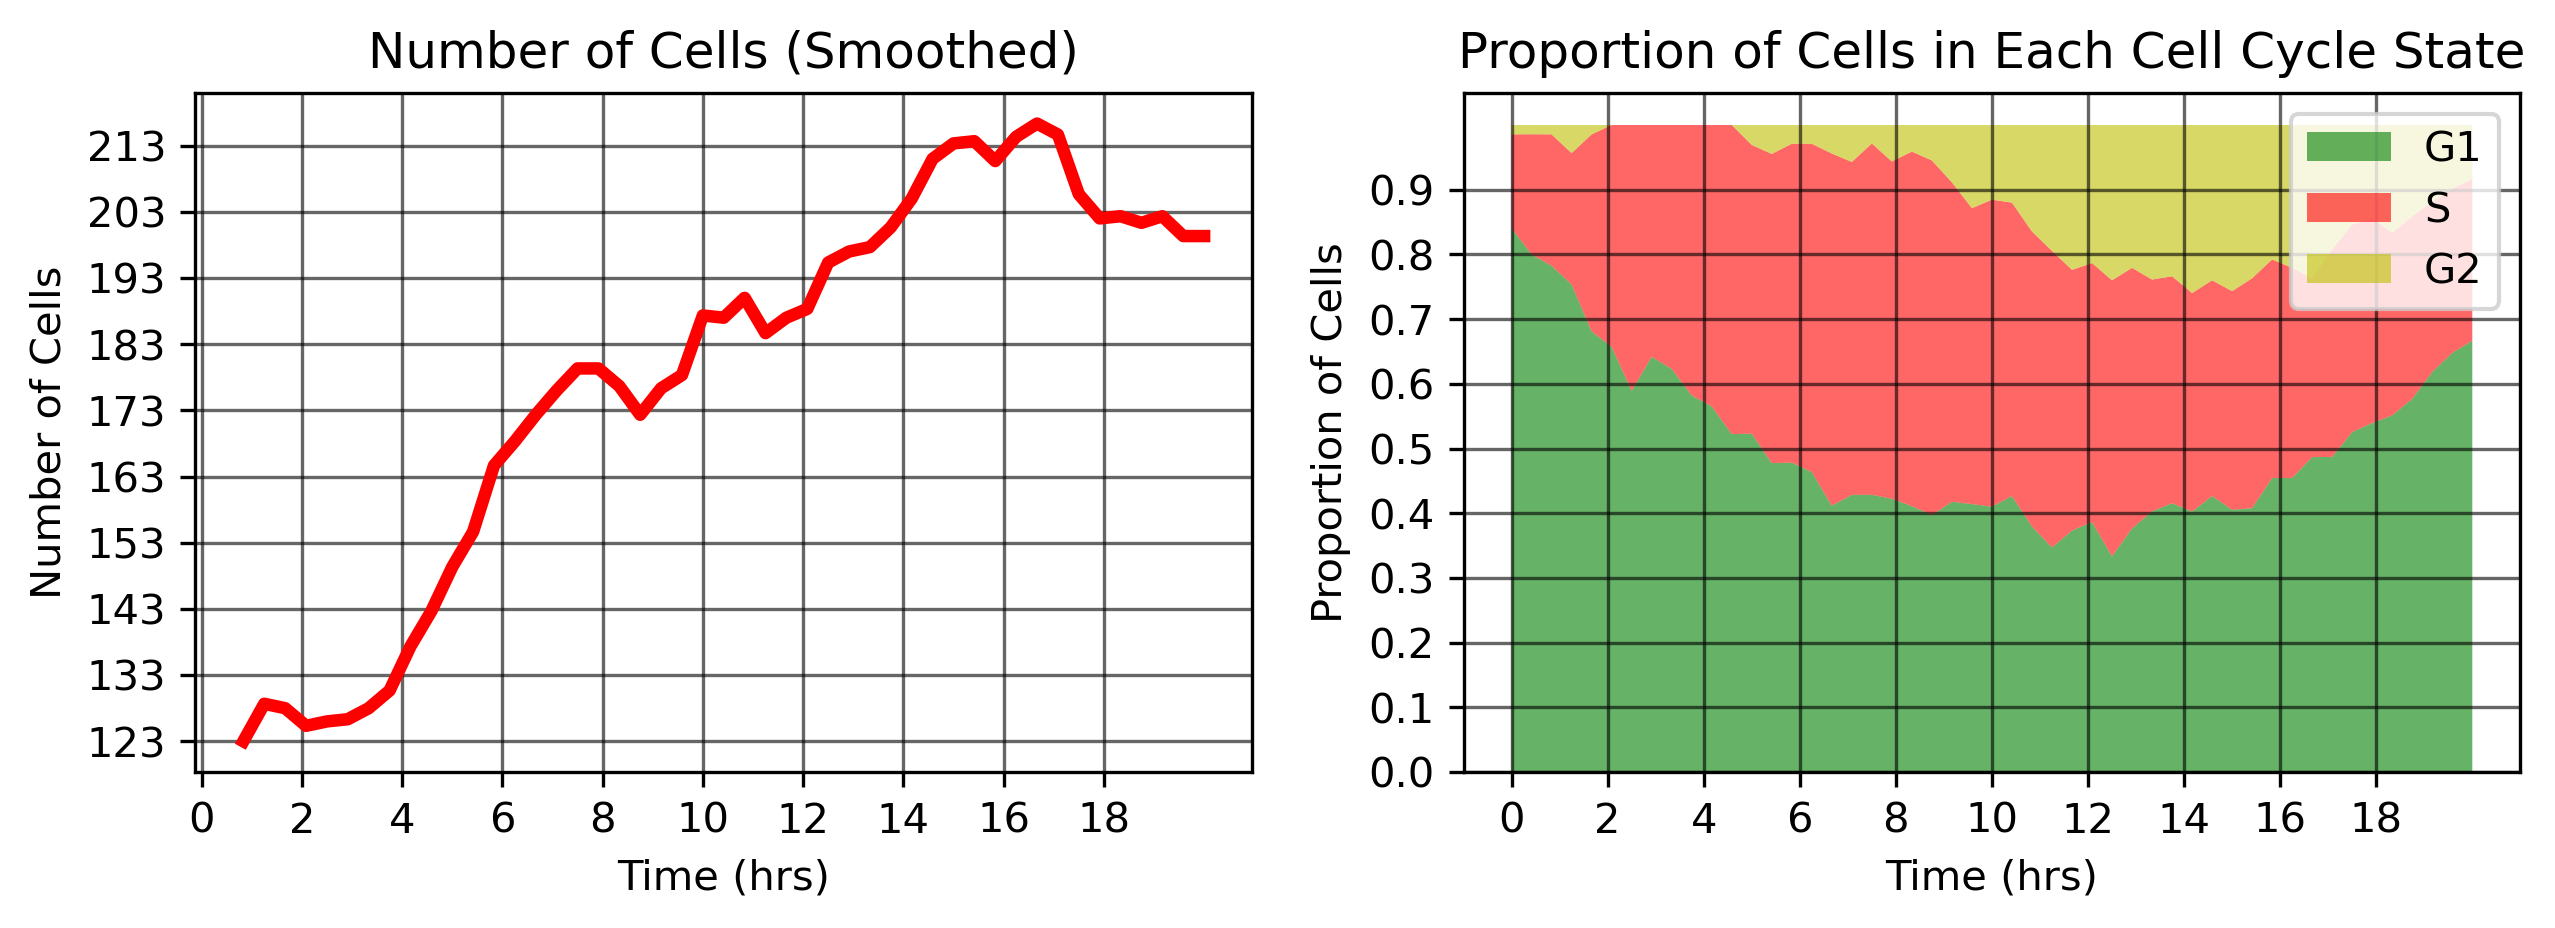

In [19]:

plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 3
plt.rcParams['figure.dpi'] = 300
fig, (ax1, ax2) = plt.subplots(1, 2)


grped['MA'] = grped['total_all'].rolling(window=3).mean()

ax1.plot(grped['Time'], grped['MA'], c='r', ls='-', lw=3)
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("Number of Cells")
ax1.set_title(f"Number of Cells (Smoothed)")

ax1.set_xticks(np.arange(0, grped['Time'].max(), 2))
ax1.set_yticks(np.arange(grped['MA'].min(), grped['MA'].max(), 10))
ax1.grid(color='k', alpha=0.6)

stack = [grped['pG1'], grped['pS'], grped['pG2']]
ax2.stackplot(grped['Time'], stack, 
              labels=['G1','S','G2'], 
              colors=['g', 'r', 'y'],
              alpha=0.6)

ax2.set_xticks(np.arange(0, grped['Time'].max(), 2))
ax2.set_yticks(np.arange(0, 1., 0.1))
ax2.grid(color='k', alpha=0.6)
ax2.legend(loc='upper right')
ax2.set_title(f"Proportion of Cells in Each Cell Cycle State")
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Proportion of Cells")


Text(0, 0.5, 'Percent of Cells')

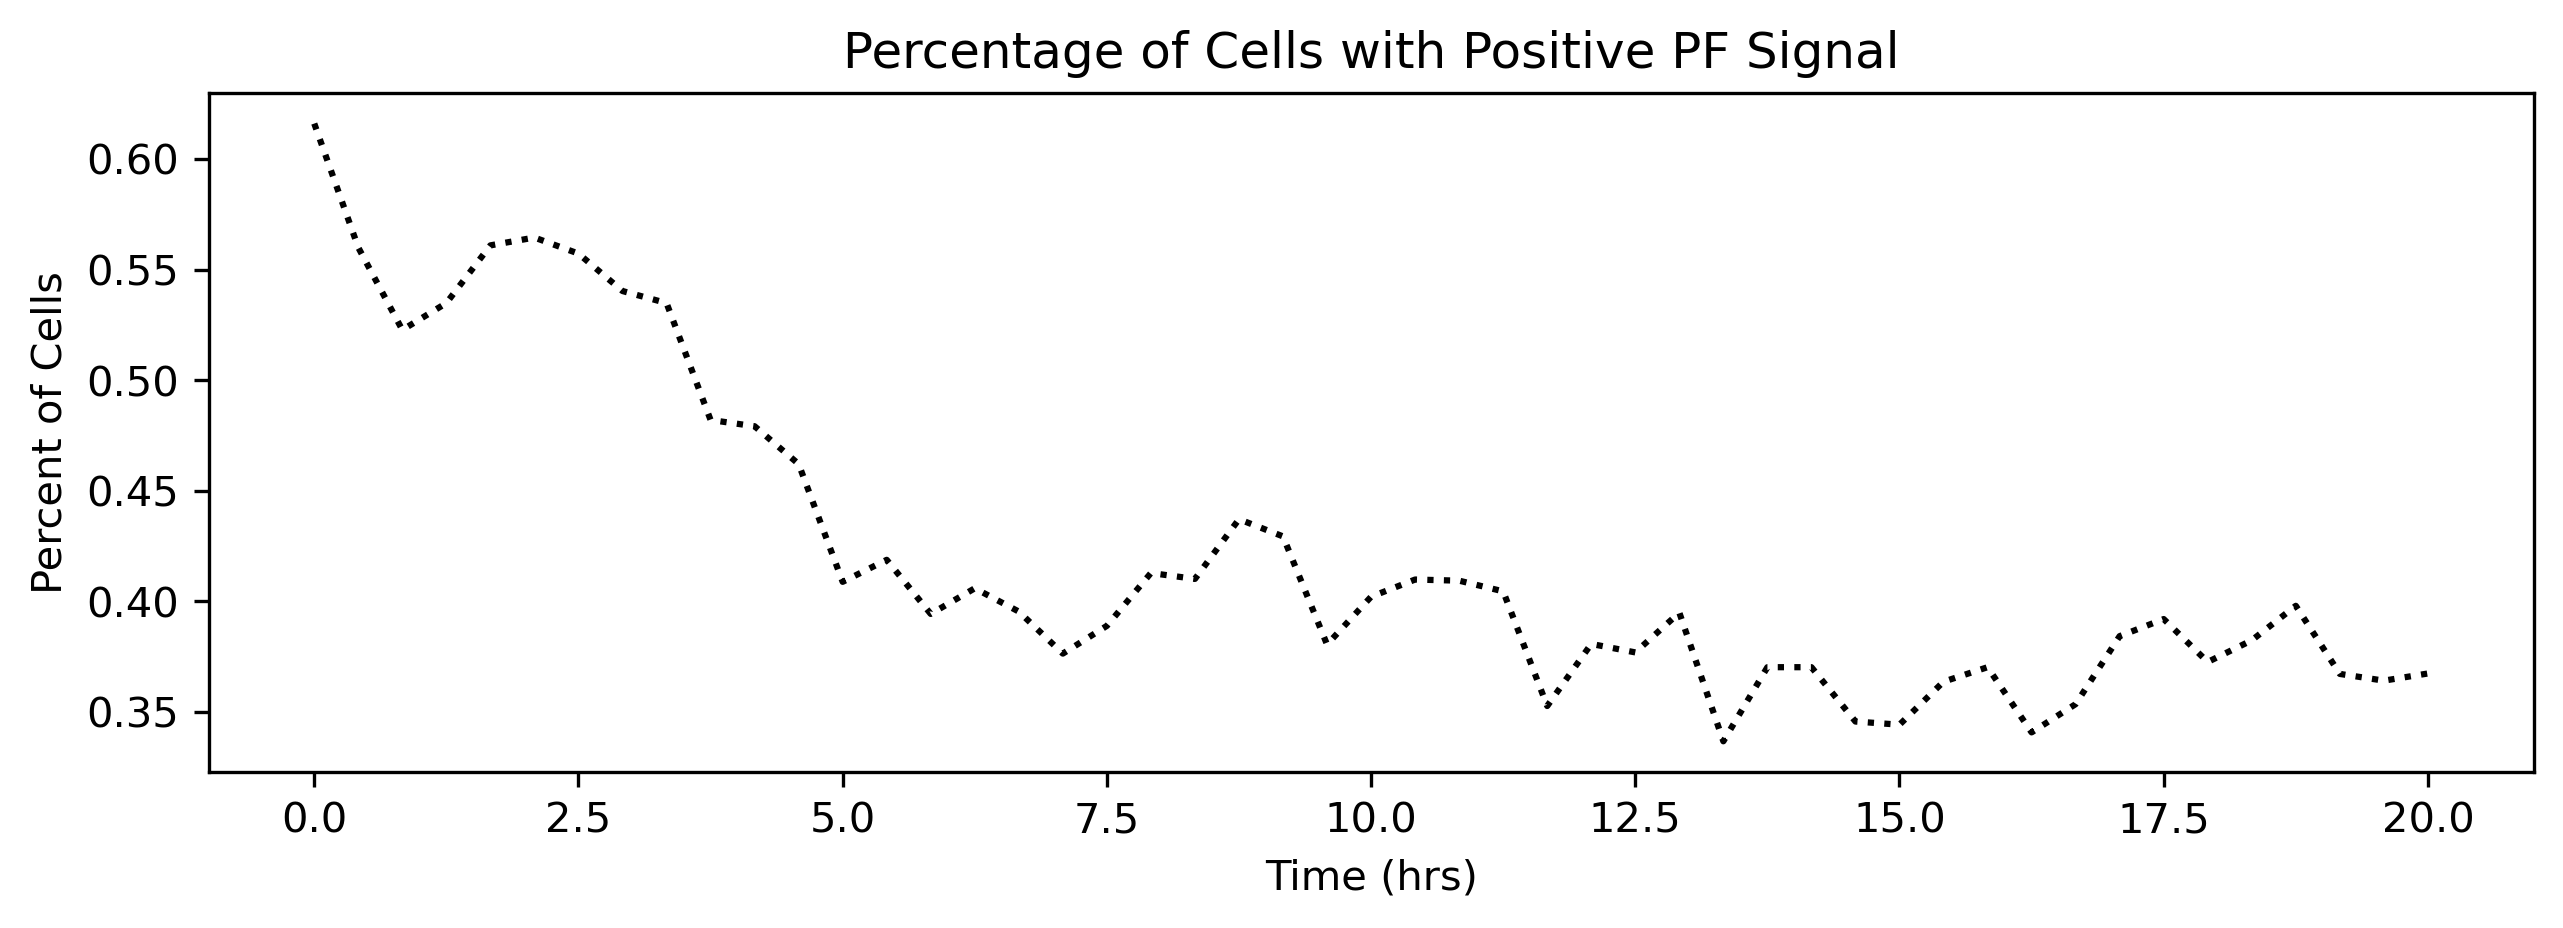

In [20]:
grped['pPF'] = grped['total'] / grped['total_all']

plt.plot(grped['Time'], grped['pPF'], c='k', ls=':')

plt.title(f"Percentage of Cells with Positive PF Signal")
plt.xlabel("Time (hrs)")
plt.ylabel("Percent of Cells")

int(rand_tid)=203
tmp.shape=(31, 55)


Text(61.583333333333336, 0.5, 'Estimated Cell Phase')

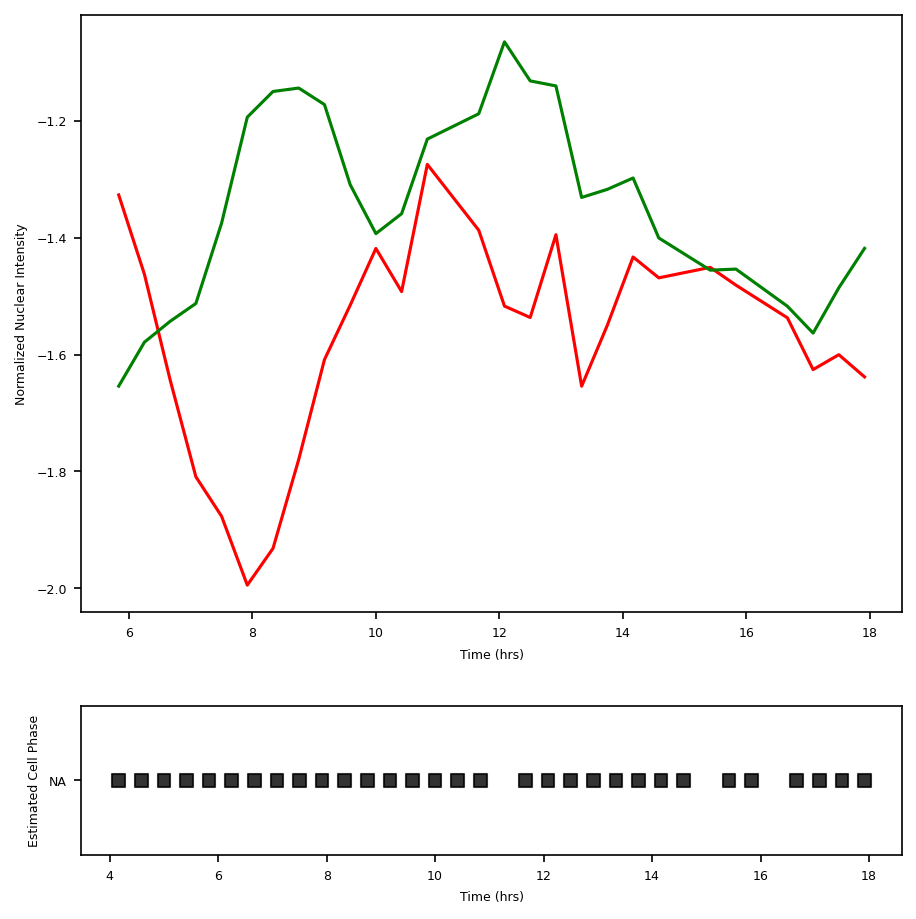

In [204]:
# visual a single track predictions

df['STEP'] = df.groupby(['TRACK_ID']).cumcount()
df['MAXSTEP'] = df.groupby(['TRACK_ID'])['FRAME'].transform("count")
df['Time'] = (df['FRAME'] * minutes_per_frame) / 60

long_tracks = df[df['MAXSTEP'] > 20.0]

rand_tid = np.random.choice(long_tracks['TRACK_ID'].unique(), 1)[0]
print(f"{int(rand_tid)=}")

tmp = df[df['TRACK_ID'] == rand_tid]
tmp = tmp.sort_values(by='FRAME').reset_index()

print(f"{tmp.shape=}")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 6
plt.rcParams['figure.figsize'] = 6, 6

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.25)

tmp['smooth_red'] = tmp['SNR_RED'].rolling(window=5).mean()
tmp['smooth_green'] = tmp['SNR_GREEN'].rolling(window=5).mean()

ax1.plot(tmp['Time'], tmp['smooth_red'], c='r')
ax1.plot(tmp['Time'], tmp['smooth_green'], c='g')
# ax1.set_title("PIP-FUCCI Reporter Signal Over Time")
ax1.set_xlabel("Time (hrs)")
ax1.set_ylabel("Normalized Nuclear Intensity")

colors = {
    'G1':'g', 
    'S':'r', 
    'G2/M':'y', 
    'NA' : 'k'
 }

ax2.scatter(tmp['Time'], 
            tmp['estimate'], 
            c = tmp['estimate'].map(colors), 
            marker="s",
            edgecolor='k',
            alpha=0.8)
n_states =  tmp['estimate'].nunique()
ax2.set_ylim(-1, n_states)
# ax2.set_title("Estimated Cell Phase")
ax2.set_xlabel("Time (hrs)")
ax2.set_ylabel("Estimated Cell Phase")